In [1]:
# if anyone else runs this you need to change the absolute path to your own
# I had to use windows paths at first
import os
os.chdir('c:\\Users\\danaceau\\Documents\\MLM_2025\\UWMadisonMLM25')

In [2]:
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from LocalLibrary import SequenceFormatter as sf
import seaborn as sns

## Define Functions


In [3]:
def create_paneled_scatterplot(data):
    """
    Generates and displays a paneled scatterplot for all unique pairs of columns
    from a given n x 4 numpy array.

    Args:
        data (np.ndarray): A NumPy array with shape (n, 4).
    """
    # Validate the input array shape
    if not isinstance(data, np.ndarray) or data.shape[1] != 4:
        raise ValueError("Input must be a NumPy array with 4 columns.")

    # --- Plotting Setup ---
    # There are 6 unique combinations of 2 columns from a set of 4 (4 choose 2).
    # We will arrange these in a 2x3 grid of subplots.
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))
    
    # Flatten the 2D axes array into a 1D array for easier iteration
    axes = axes.flatten()

    # Create descriptive labels for the columns
    column_labels = [f'PC {i+1}' for i in range(4)]

    # --- Generate Plots ---
    plot_index = 0
    # Iterate through each column index `i`
    for i in range(data.shape[1]):
        # Iterate through each subsequent column index `j` to create unique pairs
        for j in range(i + 1, data.shape[1]):
            ax = axes[plot_index]
            
            # Create a scatterplot of column i vs. column j
            ax.scatter(data[:, i], data[:, j], alpha=0.7, edgecolors='k', s=50)
            
            # Set the title and labels for the subplot
            ax.set_title(f'{column_labels[i]} vs. {column_labels[j]}', fontsize=12)
            ax.set_xlabel(column_labels[i], fontsize=10)
            ax.set_ylabel(column_labels[j], fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            
            plot_index += 1
    plt.show()

In [25]:
def get_pca_df(seq_emb_df:pd.DataFrame, n_pc=10, dim_emb=320):
    pca_model = PCA(n_components=n_pc)
    pca_model = pca_model.fit(seq_emb_df.iloc[:,:dim_emb])
    plt.scatter(x=list(range(n_pc)), 
                y=np.cumsum(pca_model.explained_variance_ratio_))
    plt.xlabel('PC #')
    plt.ylabel("Cum Exp Var")
    plt.show()
    pca_embs_wvars = pca_model.transform(seq_emb_df.iloc[:,:dim_emb])
    pca_emb_df = pd.concat([pd.DataFrame(pca_embs_wvars, index=seq_emb_df.iloc[:,dim_emb:].index,
                                        columns=[f'PC_{i}' for i in range(n_pc)]), seq_emb_df.iloc[:,dim_emb:]], axis=1)
    return pca_emb_df, pca_embs_wvars


In [135]:
def create_paneled_scatterplot_df(data:pd.DataFrame, hue_var:str, n_pcs=4, ax_lims=None,figsize=(13, 7), **kwargs):
    """
    Generates and displays a paneled scatterplot for all unique pairs of columns
    from a given n x 4 numpy array.

    Args:
        data (np.ndarray): A NumPy array with shape (n, 4).
    """
    # Validate the input array shape
    # --- Plotting Setup ---
    # There are 6 unique combinations of 2 columns from a set of 4 (4 choose 2).
    # We will arrange these in a 2x3 grid of subplots.
    if n_pcs == 4:
        fig, axes = plt.subplots(2, 3, figsize=figsize)
    else:
        fig, axes = plt.subplots(1, n_pcs, figsize=figsize)
    # Flatten the 2D axes array into a 1D array for easier iteration
    axes = axes.flatten()

    # Create descriptive labels for the columns
    column_labels = [f'PC_{i}' for i in range(4)]

    # --- Generate Plots ---
    plot_index = 0
    # Iterate through each column index `i`
    for i in range(n_pcs):
        # Iterate through each subsequent column index `j` to create unique pairs
        for j in range(i + 1, n_pcs):
            ax = axes[plot_index]
            
            # Create a scatterplot of column i vs. column j
            sns.scatterplot(data, x=f'PC_{i}', y=f'PC_{j}', hue=hue_var, ax=ax, legend=(plot_index == 0),**kwargs)
            ax.set_xlabel(column_labels[i], fontsize=10)
            ax.set_ylabel(column_labels[j], fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            if plot_index == 0:
                ax.legend(bbox_to_anchor=(-0.2, 1))
            if ax_lims is not None:
                ax.set_xlim(ax_lims[i])
                ax.set_ylim(ax_lims[j])
            
            plot_index += 1
    plt.tight_layout()
    plt.show()

In [6]:
seq_table = pd.read_csv("Config\\sequence_data.csv")
proteins = seq_table['Sequence'].to_list()

In [7]:
seq_table['Sequence'].str.len().value_counts()

Sequence
174    3
360    2
326    2
505    2
196    2
      ..
138    1
204    1
219    1
384    1
83     1
Name: count, Length: 129, dtype: int64

In [8]:
from sklearn.decomposition import PCA

In [9]:
# This is the 35M Param ESM model we can use whatever, but I only have cpu resources 
# DW about the warning, it just does that
esm_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_name)
model = EsmModel.from_pretrained(esm_name)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Embed WT sequences to learn to use ESM and make a quick plot

In [31]:
# Tokenize sequences
tokenized_seqs = tokenizer(proteins, padding=True, return_tensors="pt")

In [32]:
# Make some batches (THis is for running on a laptop)
inds = [5*i for i in range(tokenized_seqs['input_ids'].shape[0]//5 + 1)]
batched_seqs = [{key:tokenized_seqs[key][ind1:ind2, :] for key in tokenized_seqs.keys()} for ind1, ind2 in zip(inds[:-1], inds[1:])]

In [42]:
batched_seqs[0]['input_ids'].detach()

tensor([[ 0, 20,  9,  ...,  1,  1,  1],
        [ 0, 20,  9,  ...,  1,  1,  1],
        [ 0, 20, 13,  ...,  1,  1,  1],
        [ 0, 20,  5,  ...,  1,  1,  1],
        [ 0, 20, 13,  ...,  1,  1,  1]])

In [33]:
# We're gonna batch this bc I have 16gb ram on my laptop and I don't have GPUs for PR
model.eval()
batched_res = []
for i, batch in enumerate(batched_seqs):
    with torch.no_grad():
        model_out = model(**batch)
    batched_res.append(model_out.pooler_output)
    print(f'finished batch {i}')
    del model_out
batched_res

finished batch 0


KeyboardInterrupt: 

In [ ]:
np_embs = torch.cat(batched_res, dim=0).detach().numpy()
np_embs

array([[ 0.1361863 , -0.06730558, -0.14604113, ..., -0.06707063,
        -0.03830042,  0.10917517],
       [ 0.12563314,  0.01432397, -0.23303987, ..., -0.1574275 ,
        -0.02407403,  0.07864276],
       [ 0.1623456 ,  0.02123156, -0.1710814 , ..., -0.11399984,
         0.00452244,  0.11488131],
       ...,
       [ 0.13236551, -0.06433567, -0.15349412, ..., -0.07644798,
        -0.06174849,  0.09548871],
       [ 0.1190526 , -0.05066854, -0.14971675, ..., -0.10777874,
        -0.01173955,  0.16488433],
       [ 0.1645001 , -0.05967285, -0.23026304, ..., -0.09263757,
         0.02070582,  0.04990286]], shape=(135, 320), dtype=float32)

In [ ]:
np.savetxt("data\zdanaceau_out_data\esm_6M_embs.csv", np_embs, delimiter=',')

<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:2: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_34004\3287000484.py:2: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\esm_6M_embs.csv", np_embs, delimiter=',')
C:\Users\danaceau\AppData\Local\Temp\ipykernel_34004\3287000484.py:2: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\esm_6M_embs.csv", np_embs, delimiter=',')


NameError: name 'np_embs' is not defined

In [ ]:
np_embs = np.loadtxt("data\zdanaceau_out_data\esm_6M_embs.csv", delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_34004\1187572732.py:1: SyntaxWarning: invalid escape sequence '\z'
  np_embs = np.loadtxt("data\zdanaceau_out_data\esm_6M_embs.csv", delimiter=',')


In [ ]:
pca_model = PCA(n_components=10)
pca_model = pca_model.fit(np_embs)
pca_embs = pca_model.transform(np_embs)
pca_embs

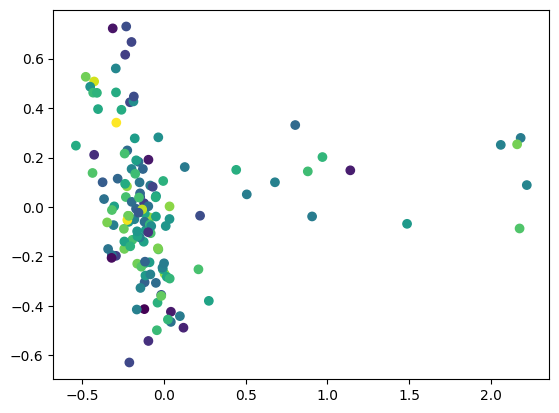

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pca_embs[:, 0], pca_embs[:,1], c=pca_embs[:,3])

Text(0.5, 0, 'PC #')

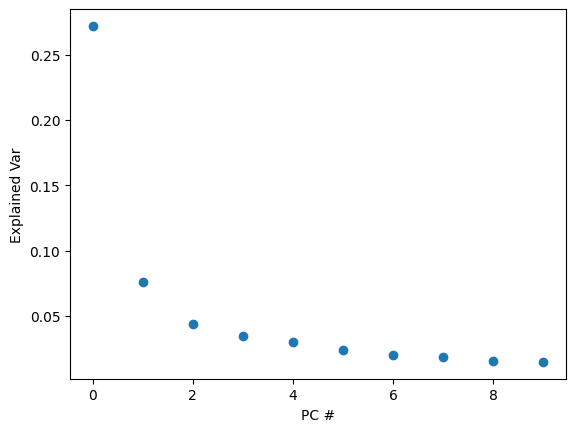

In [ ]:
plt.scatter(list(range(len(pca_model.explained_variance_))), pca_model.explained_variance_)
plt.ylabel("Explained Var")
plt.xlabel("PC #")

In [ ]:
def create_paneled_scatterplot(data):
    """
    Generates and displays a paneled scatterplot for all unique pairs of columns
    from a given n x 4 numpy array.

    Args:
        data (np.ndarray): A NumPy array with shape (n, 4).
    """
    # Validate the input array shape
    if not isinstance(data, np.ndarray) or data.shape[1] != 4:
        raise ValueError("Input must be a NumPy array with 4 columns.")

    # --- Plotting Setup ---
    # There are 6 unique combinations of 2 columns from a set of 4 (4 choose 2).
    # We will arrange these in a 2x3 grid of subplots.
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))
    
    # Flatten the 2D axes array into a 1D array for easier iteration
    axes = axes.flatten()

    # Create descriptive labels for the columns
    column_labels = [f'PC {i+1}' for i in range(4)]

    # --- Generate Plots ---
    plot_index = 0
    # Iterate through each column index `i`
    for i in range(data.shape[1]):
        # Iterate through each subsequent column index `j` to create unique pairs
        for j in range(i + 1, data.shape[1]):
            ax = axes[plot_index]
            
            # Create a scatterplot of column i vs. column j
            ax.scatter(data[:, i], data[:, j], alpha=0.7, edgecolors='k', s=50)
            
            # Set the title and labels for the subplot
            ax.set_title(f'{column_labels[i]} vs. {column_labels[j]}', fontsize=12)
            ax.set_xlabel(column_labels[i], fontsize=10)
            ax.set_ylabel(column_labels[j], fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            
            plot_index += 1
    plt.show()

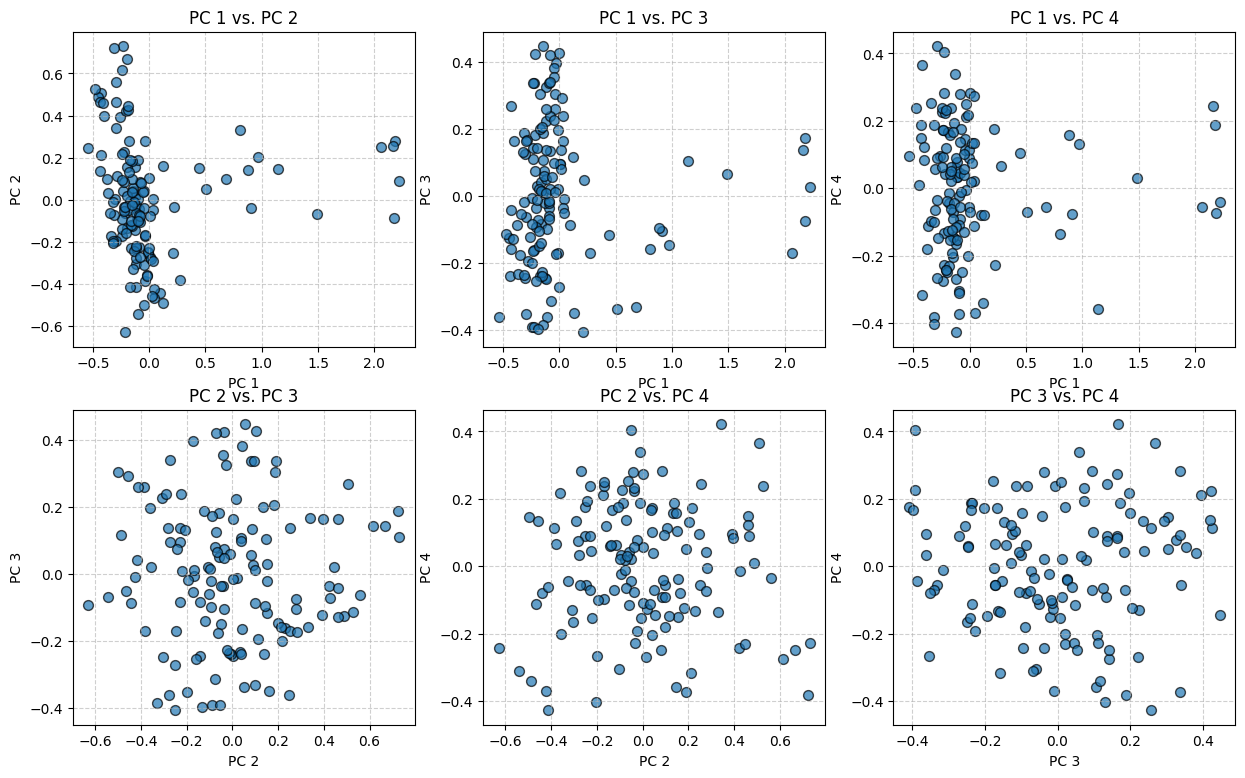

In [ ]:
create_paneled_scatterplot(pca_embs[:,:4])

## Embed Variants
- Additional things
    - UMAP plots
    - Residue LLs
- Make a script for the embedding and move to platformR


In [43]:
train_vnts = pd.read_csv("data\\mave-db-amino-acid-substitution-prediction\\train.csv")

### Preprocessing
Subsetting data for comp speed


In [44]:
vnt_sub_list =[]
for esnp in train_vnts['ensp'].unique():
    esnp_vnts = train_vnts[train_vnts['ensp'] == esnp]
    vnt_sub_list.append(esnp_vnts.iloc[np.random.choice(esnp_vnts.shape[0], size=10),:])
train_vnts_sub = pd.concat(vnt_sub_list, axis=0).reset_index(drop=True)
train_vnts_sub

accession                 scoreset  \
0                       urn:mavedb:00000069-a-2#883  urn:mavedb:00000069-a-2   
1                      urn:mavedb:00000069-a-2#1649  urn:mavedb:00000069-a-2   
2                      urn:mavedb:00000069-a-2#1362  urn:mavedb:00000069-a-2   
3                      urn:mavedb:00000069-a-2#1966  urn:mavedb:00000069-a-2   
4                      urn:mavedb:00000069-a-2#1847  urn:mavedb:00000069-a-2   
...                                             ...                      ...   
1355  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#6778  urn:mavedb:00001200-d-1   
1356  tmp:8758394a-9513-4948-ba9e-71a33a593406#5954  urn:mavedb:00001200-c-1   
1357  tmp:1a14f665-fcc5-4244-baae-e22da846c65f#8710  urn:mavedb:00001200-a-1   
1358  tmp:1a14f665-fcc5-4244-baae-e22da846c65f#5609  urn:mavedb:00001200-a-1   
1359  tmp:8758394a-9513-4948-ba9e-71a33a593406#5545  urn:mavedb:00001200-c-1   

                   ensp  pos ref_long ref_short alt_long alt_short     score  
0     ENSP00000252519.3  388      Gln         Q      Arg         R  0.144561  
1     ENSP00000252519.3   38      Asp         D      Gly         G  1.473527  
2     ENSP00000252519.3   73      Leu         L      Ser         S -0.242906  
3     ENSP00000252519.3   24      Gln         Q      Cys         C  1.998532  
4     ENSP00000252519.3   30      Asp         D      Ile         I -3.832439  
...                 ...  ...      ...       ...      ...       ...       ...  
1355  ENSP00000218099.2  323      Glu         E      Arg         R  0.798285  
1356  ENSP00000218099.2  284      Ile         I      Leu         L  1.094339  
1357  ENSP00000218099.2  415      His         H      Arg         R  0.094581  
1358  ENSP00000218099.2  268      Cys         C      Ala         A  0.056259  
1359  ENSP00000218099.2  264      Thr         T      Tyr         Y  0.024049  

[1360 rows x 9 columns]

Get variant sequences

In [45]:
train_vnts_sub['sequence'] = [
    sf.LoadSequenceData_FromDfRow(train_vnts_sub.iloc[idx,:]) for idx in range(train_vnts_sub.shape[0])
    ]
train_vnts_sub

accession                 scoreset  \
0                       urn:mavedb:00000069-a-2#883  urn:mavedb:00000069-a-2   
1                      urn:mavedb:00000069-a-2#1649  urn:mavedb:00000069-a-2   
2                      urn:mavedb:00000069-a-2#1362  urn:mavedb:00000069-a-2   
3                      urn:mavedb:00000069-a-2#1966  urn:mavedb:00000069-a-2   
4                      urn:mavedb:00000069-a-2#1847  urn:mavedb:00000069-a-2   
...                                             ...                      ...   
1355  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#6778  urn:mavedb:00001200-d-1   
1356  tmp:8758394a-9513-4948-ba9e-71a33a593406#5954  urn:mavedb:00001200-c-1   
1357  tmp:1a14f665-fcc5-4244-baae-e22da846c65f#8710  urn:mavedb:00001200-a-1   
1358  tmp:1a14f665-fcc5-4244-baae-e22da846c65f#5609  urn:mavedb:00001200-a-1   
1359  tmp:8758394a-9513-4948-ba9e-71a33a593406#5545  urn:mavedb:00001200-c-1   

                   ensp  pos ref_long ref_short alt_long alt_short     score  \
0     ENSP00000252519.3  388      Gln         Q      Arg         R  0.144561   
1     ENSP00000252519.3   38      Asp         D      Gly         G  1.473527   
2     ENSP00000252519.3   73      Leu         L      Ser         S -0.242906   
3     ENSP00000252519.3   24      Gln         Q      Cys         C  1.998532   
4     ENSP00000252519.3   30      Asp         D      Ile         I -3.832439   
...                 ...  ...      ...       ...      ...       ...       ...   
1355  ENSP00000218099.2  323      Glu         E      Arg         R  0.798285   
1356  ENSP00000218099.2  284      Ile         I      Leu         L  1.094339   
1357  ENSP00000218099.2  415      His         H      Arg         R  0.094581   
1358  ENSP00000218099.2  268      Cys         C      Ala         A  0.056259   
1359  ENSP00000218099.2  264      Thr         T      Tyr         Y  0.024049   

                                               sequence  
0     MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...  
1     MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEGLFYQSSLA...  
2     MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...  
3     MSSSSWLLLSLVAVTAAQSTIEECAKTFLDKFNHEAEDLFYQSSLA...  
4     MSSSSWLLLSLVAVTAAQSTIEEQAKTFLIKFNHEAEDLFYQSSLA...  
...                                                 ...  
1355  MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...  
1356  MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...  
1357  MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...  
1358  MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...  
1359  MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...  

[1360 rows x 10 columns]

In [46]:
base_seq_map = seq_table.set_index('ID')['Sequence'].to_dict()
base_seq_map

{'ENSP00000336856.4': 'MENLMTSSTLPPLFADEDGSKESNDLATTGLNHPEVPYSSGATSSTNNPEFVEDLSQGQLLQSESSNAAEGNEQRHEDEQRSKRGGWSKGRKRKKPLRDSNAPKSPLTGYVRFMNERREQLRAKRPEVPFPEITRMLGNEWSKLPPEEKQRYLDEADRDKERYMKELEQYQKTEAYKVFSRKTQDRQKGKSHRQDAARQATHDHEKETEVKERSVFDIPIFTEEFLNHSKAREAELRQLRKSNMEFEERNAALQKHVESMRTAVEKLEVDVIQERSRNTVLQQHLETLRQVLTSSFASMPLPGSGETPTVDTIDSYMNRLHSIILANPQDNENFIATVREVVNRLDR',
 'ENSP00000309606.2': 'MEEAEELLLEGKKALQLAREPRLGLDLGWNPSGEGCTQGLKDVPPEPTRDILALKSLPRGLALGPSLAKEQRLGVWCVGDPLQPGLLWGPLEEESASKEKGEGVKPRQEENLSLGPWGDVCACEQSSGWTSLVQRGRLESEGNVAPVRISERLHLQVYQLVLPGSELLLWPQPSSEGPSLTQPGLDKEAAVAVVTEVESAVQQEVASPGEDAAEPCIDPGSQSPSGIQAENMVSPGLKFPTQDRISKDSQPLGPLLQDGDVDEECPAQAQMPPELQSNSATQQDPDGSGASFSSSARGTQPHGYLAKKLHSPSDQCPPRAKTPEPGAQQSGFPTLSRSPPGPAGSSPKQGRRYRCGECGKAFLQLCHLKKHAFVHTGHKPFLCTECGKSYSSEESFKAHMLGHRGVRPFPCPQCDKAYGTQRDLKEHQVVHSGARPFACDQCGKAFARRPSLRLHRKTHQVPAAPAPCPCPVCGRPLANQGSLRNHMRLHTGEKPFLCPHCGRAFRQRGNLRGHLRLHTGERPYRCPHCADAFPQLPELRRHLISHTGEAHLCPVCGKALRDPHTLRAHERLHSGERPFPCPQCGRAYTLATKLRRHLKSHLED

In [47]:
vnt_proteins = train_vnts_sub['sequence'].to_list()
tokenized_vnts = tokenizer(vnt_proteins, padding=True, return_tensors='pt')

In [49]:
tokenized_vnts['input_ids'].shape

torch.Size([1360, 4836])

In [ ]:
# Yes I know this is not efficient
orig_prots = train_vnts_sub['ensp'].map(base_seq_map).to_list()
tokenized_orig = tokenizer(orig_prots, padding=True, return_tensors='pt')

In [ ]:
tokenized_vnts.d

### Compute embeddings 

Batch Sequences

In [ ]:
# Make some batches (THis is for running on a laptop)
inds = [10*i for i in range(tokenized_vnts['input_ids'].shape[0]//10 + 1)]
batched_pos = [train_vnts_sub.loc[ind1:ind2-1, 'pos'].to_list() for ind1, ind2 in zip(inds[:-1], inds[1:])]
batched_vnts = [{key:tokenized_vnts[key][ind1:ind2, :] for key in tokenized_vnts.keys()} for ind1, ind2 in zip(inds[:-1], inds[1:])]
batched_orig = [{key:tokenized_orig[key][ind1:ind2, :] for key in tokenized_orig.keys()} for ind1, ind2 in zip(inds[:-1], inds[1:])]

Get Embeddings

In [74]:
# We're gonna batch this bc I have 16gb ram on my laptop and I don't have GPUs for PR
# IK there is a more efficient way to do this too. I should have cached the whole AA level
#       seq embedding and then pulled aas from that cache. This was easier.
model.eval()
batched_vnt_emb = []
batched_orig_emb = []
batched_mut_aa_emb = []
batched_orig_aa_emb = []

for i, batch in enumerate(batched_vnts):
    with torch.no_grad():
        model_out_var = model(**batch)
        model_out_orig = model(**batched_orig[i])
    # Stack the mutants embeddings together
    # last_hidden_state has dimensionality (n_seqs, max_seq_len*, emb_dim)
    #   *I use this loosely theres some padding and stuff
    # BC the first index is padded we can just use the positions who's indices start at 1 so thats nice
    batch_mut_aa_emb = []
    batch_orig_aa_emb = []
    for seq_ind, pos in enumerate(batched_pos[i]):
        batch_mut_aa_emb.append(model_out_var.last_hidden_state[seq_ind, pos, :])
        batch_orig_aa_emb.append(model_out_orig.last_hidden_state[seq_ind, pos, :])
    batched_mut_aa_emb.append(torch.stack(batch_mut_aa_emb, dim=0))
    batched_orig_aa_emb.append(torch.stack(batch_orig_aa_emb, dim=0))
    # pooler output is (n_seqs, emb_dim) These are sequence embeddings
    batched_vnt_emb.append(model_out_var.pooler_output)
    batched_orig_emb.append(model_out_orig.pooler_output)
    print(f'finished batch {i}')
    del model_out_var
    del model_out_orig


finished batch 0
finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
finished batch 16
finished batch 17
finished batch 18
finished batch 19
finished batch 20
finished batch 21
finished batch 22
finished batch 23
finished batch 24
finished batch 25
finished batch 26
finished batch 27
finished batch 28
finished batch 29
finished batch 30
finished batch 31
finished batch 32
finished batch 33
finished batch 34
finished batch 35
finished batch 36
finished batch 37
finished batch 38
finished batch 39
finished batch 40
finished batch 41
finished batch 42
finished batch 43
finished batch 44
finished batch 45
finished batch 46
finished batch 47
finished batch 48
finished batch 49
finished batch 50
finished batch 51
finished batch 52
finished batch 53
finished batch 54
finished batch 55
fi

RuntimeError: cannot reshape tensor of 0 elements into shape [0, 4836, -1, 16] because the unspecified dimension size -1 can be any value and is ambiguous

Save Embeddings

In [10]:
np_vnt_embs = torch.cat(batched_vnt_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv", np_vnt_embs,
           delimiter=',')
np_orig_embs = torch.cat(batched_orig_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv", np_orig_embs,
           delimiter=',')
np_vnt_aa_embs = torch.cat(batched_mut_aa_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv", np_vnt_aa_embs,
           delimiter=',')
np_orig_aa_embs = torch.cat(batched_orig_aa_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_aa_embs.csv", np_orig_aa_embs,
           delimiter=',')
# Save this since subset can be different since its random and I forgot to seed
train_vnts_sub.to_csv("data\\zdanaceau_out_data\\seq_res_embs\\vnt_subset_info.csv")

<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:5: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\z'
<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:5: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_6060\2177480116.py:2: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv", np_vnt_embs,
C:\Users\danaceau\AppData\Local\Temp\ipykernel_6060\2177480116.py:5: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv", np_orig_embs,
C:\Users\danaceau\AppData\Local\Temp\ipykernel_6060\2177480116.py:8: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv", np_vnt_aa

NameError: name 'batched_vnt_emb' is not defined

Load embeddings (They take a couple hours)

### Explore Embeddings

In [10]:

np_vnt_embs= np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv", 
           delimiter=',')

np_orig_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv", 
           delimiter=',')

np_vnt_aa_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv", 
           delimiter=',')
np_orig_aa_embs = np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_aa_embs.csv",
           delimiter=',')
# Save this since subset can be different since its random and I forgot to seed
train_vnts_sub=pd.read_csv("data\\zdanaceau_out_data\\seq_res_embs\\vnt_subset_info.csv")

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:9: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:9: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_23900\2383516881.py:1: SyntaxWarning: invalid escape sequence '\z'
  np_vnt_embs= np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv",
C:\Users\danaceau\AppData\Local\Temp\ipykernel_23900\2383516881.py:4: SyntaxWarning: invalid escape sequence '\z'
  np_orig_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv",
C:\Users\danaceau\AppData\Local\Temp\ipykernel_23900\2383516881.py:7: SyntaxWarning: invalid escape sequence '\z'
  np_vnt_aa_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.

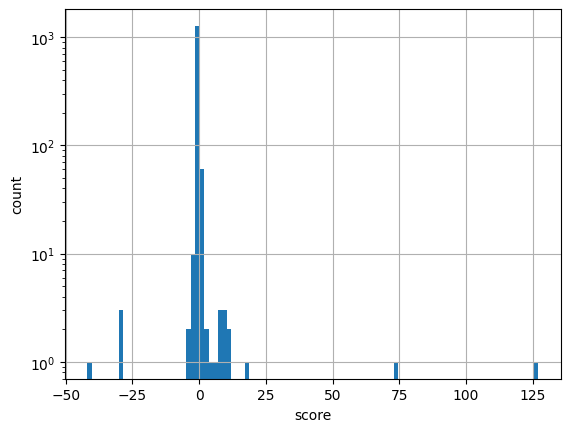

In [11]:
# Score distribution has some outliers, clip to +/-15
train_vnts_sub['score'].hist(bins=100)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('score')
plt.show()

#### Full Seq Embeddings

In [12]:
train_vnts_sub['score'] = train_vnts_sub['score'].clip(-15,15)
train_vnts_sub['abs_score'] = train_vnts_sub['score'].abs()

In [13]:
seq_emb_df = pd.concat(
    [pd.concat([pd.DataFrame(np_orig_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1),
     pd.concat([pd.DataFrame(np_vnt_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1)],
     axis=0
)
seq_emb_df['prot_version'] = ['orig' for i in range(1360)] + ['var' for i in range(1360)]

PCA Plot
- It should be apparent that there is virtuall no diff in embedding here

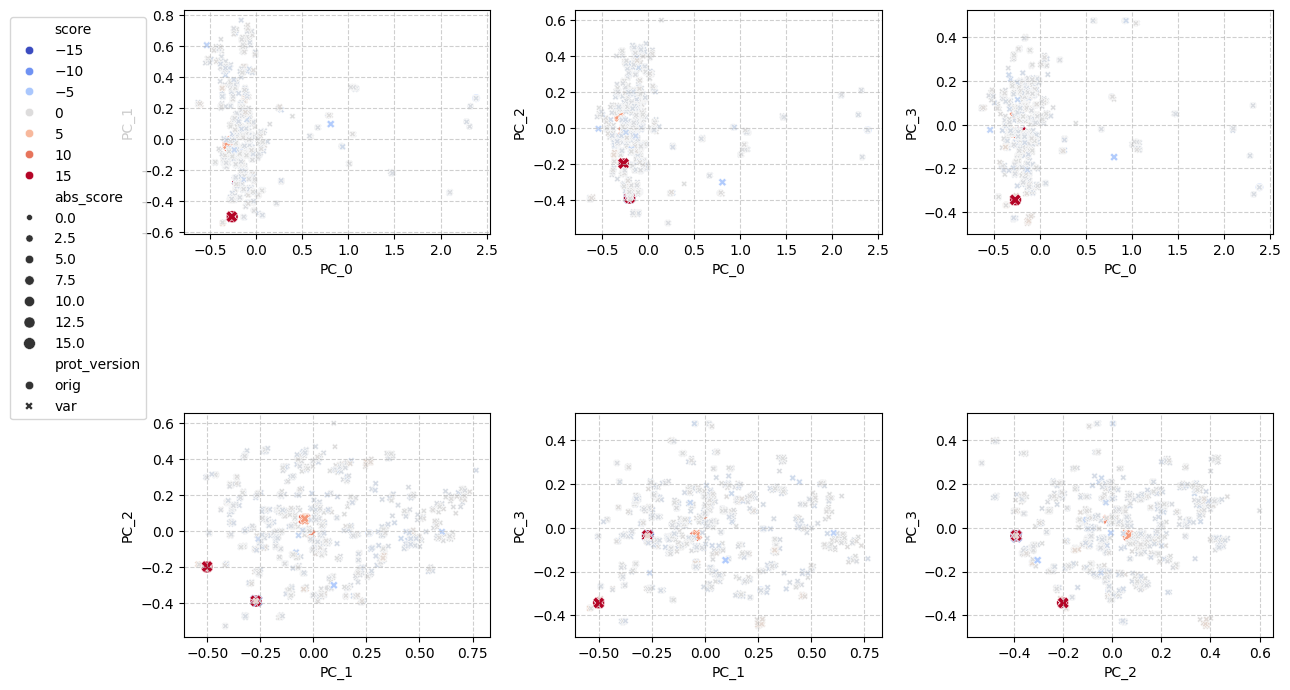

In [14]:
pca_emb_df = get_pca_df(seq_emb_df)
create_paneled_scatterplot_df(pca_emb_df, style='prot_version', hue_var='score', palette='coolwarm', size='abs_score'
                              )

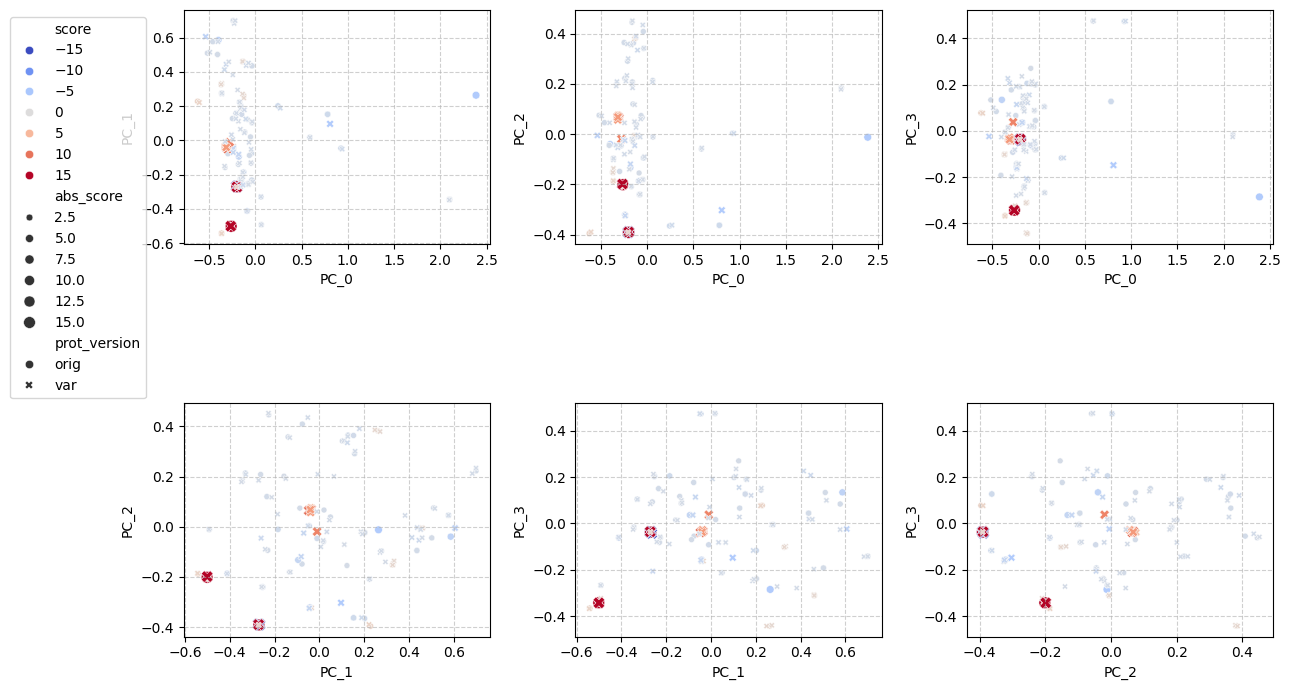

In [15]:
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['abs_score'] > 1],style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')

Mutated AA embs
- Now we see a difference (not really apparent unless I get rid of all the 0s, hence subset to |score| > 1)

In [16]:
aa_emb_df = pd.concat(
    [pd.concat([pd.DataFrame(np_orig_aa_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1),
     pd.concat([pd.DataFrame(np_vnt_aa_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1)],
     axis=0
)
aa_emb_df['prot_version'] = ['orig' for i in range(1360)] + ['var' for i in range(1360)]

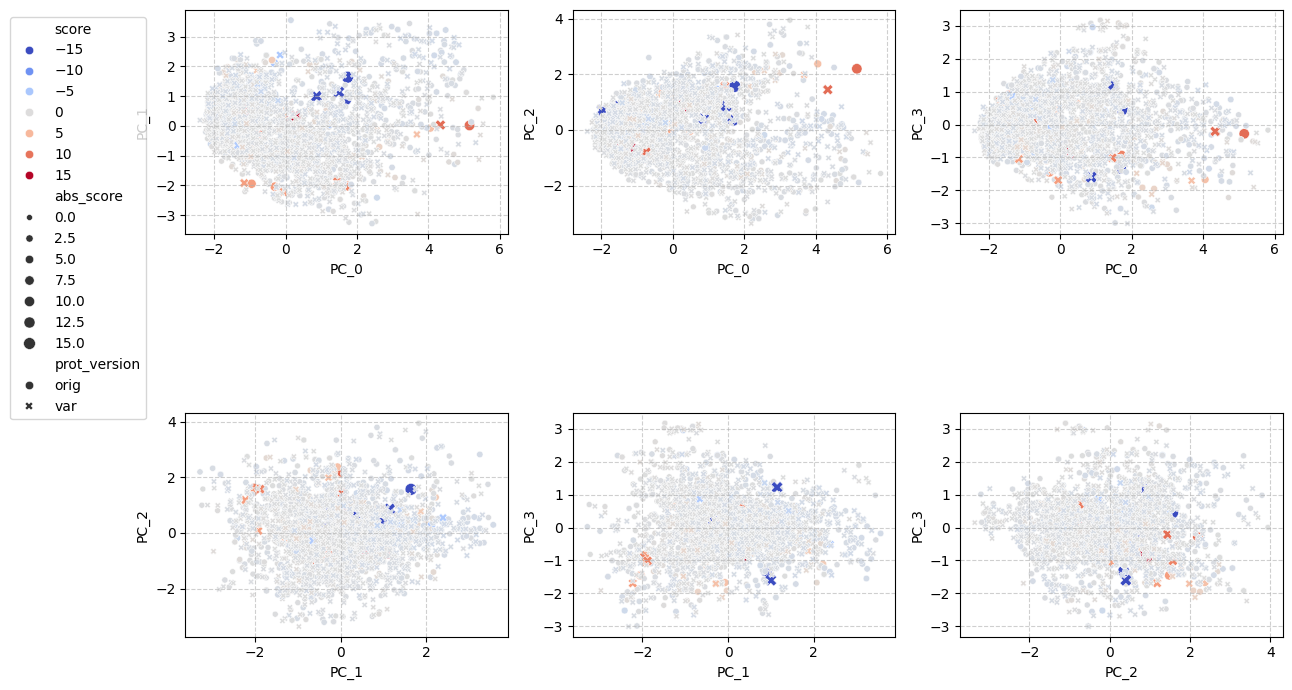

In [17]:
pca_emb_df = get_pca_df(aa_emb_df)
create_paneled_scatterplot_df(pca_emb_df,  style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')

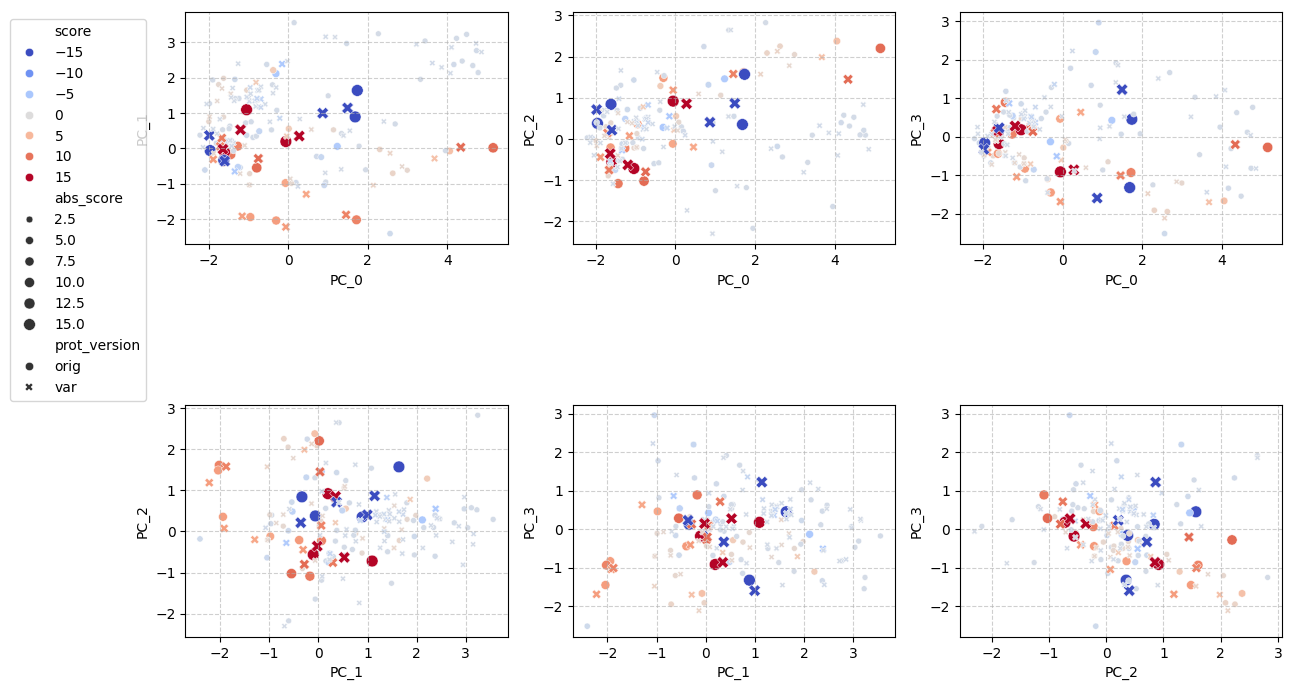

In [18]:
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['abs_score'] > 1],style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')
                        

Diffs between residue embeddings

In [22]:
aa_diff_emb_df = pd.concat(
    [pd.DataFrame(np_vnt_aa_embs - np_orig_aa_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1
    )


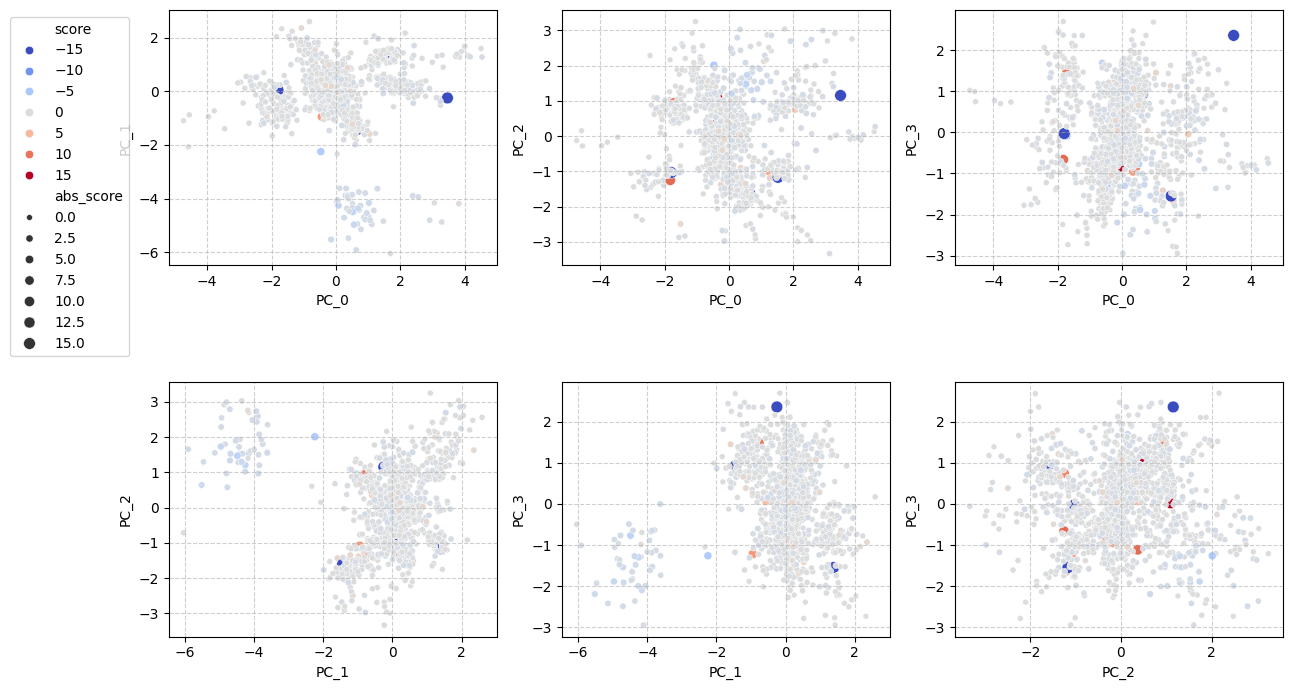

In [25]:
pca_emb_df = pca_emb_df = get_pca_df(aa_diff_emb_df)
create_paneled_scatterplot_df(pca_emb_df, hue_var='score', size='abs_score', palette='coolwarm')

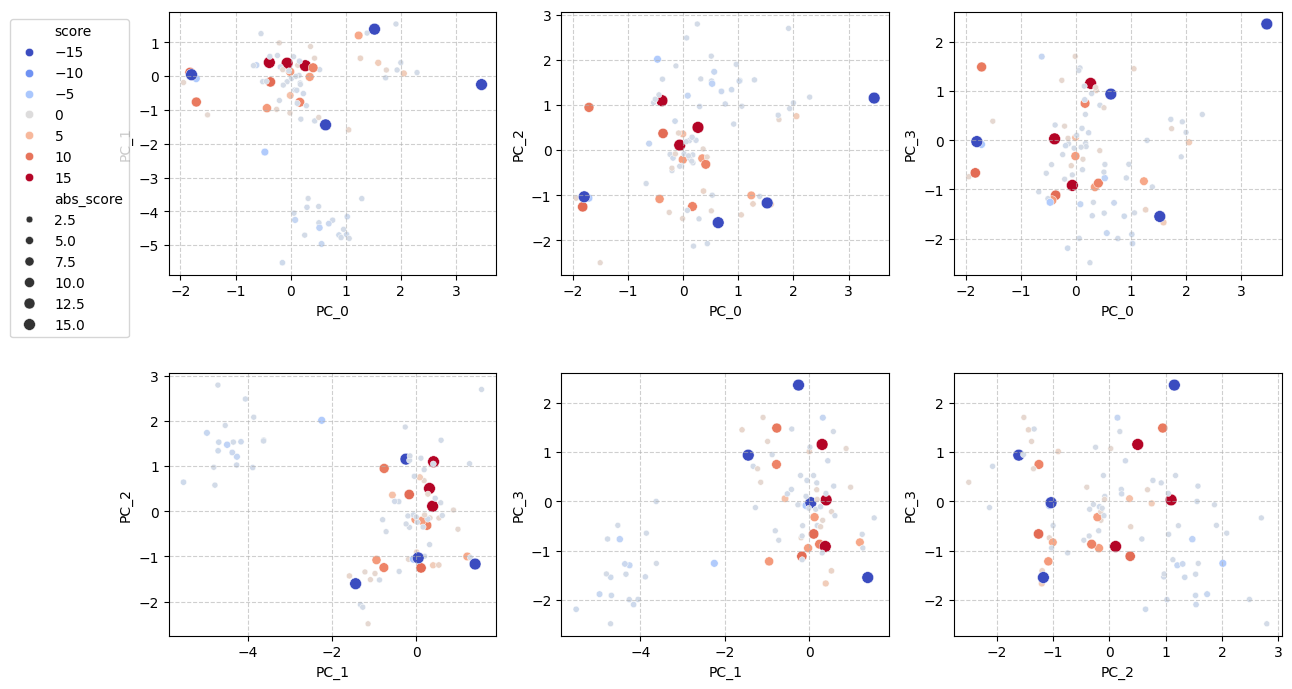

In [24]:
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['abs_score'] > 1],  hue_var='score', size='abs_score', palette='coolwarm')

## Save addtl models to load later in PlatformR 

Small 8M model

In [18]:
esm_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_name)
model = EsmModel.from_pretrained(esm_name)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
tokenizer.save_pretrained("esm_models\\esm2_t6_8M_UR50D\\tokenizer")
model.save_pretrained("esm_models\\esm2_t6_8M_UR50D\\model")

Large 650 M model

In [20]:
esm_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_name)
model = EsmModel.from_pretrained(esm_name)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

c:\Users\danaceau\AppData\Local\miniconda3\envs\mlm_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\danaceau\.cache\huggingface\hub\models--facebook--esm2_t33_650M_UR50D. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
tokenizer.save_pretrained("esm_models\\esm2_t33_650M_UR50D\\tokenizer")
model.save_pretrained("esm_models\\esm2_t33_650M_UR50D\\model")

## Process full ESM embeddings

In [10]:
def load_emb_set(emb_path:str, md_pth:str, load_train=True, load_test=True):
    def load_emb_set(filename):
        emb_list = []
        if load_train:
            emb_list.append(np.loadtxt(os.path.join(emb_path, 'train', filename), delimiter=','))
        if load_test:
            emb_list.append(np.loadtxt(os.path.join(emb_path, 'test', filename), delimiter=','))
        return np.concat(emb_list, axis=0), [arr.shape[0] for arr in emb_list]
    orig_aa_embs, shapes = load_emb_set('orig_aa_embs.csv')
    var_aa_embs,shapes = load_emb_set('var_aa_embs.csv')
    orig_embs,shapes = load_emb_set('orig_embs.csv')
    var_embs,shapes = load_emb_set('var_embs.csv')
    md_dfs = []
    if load_train:
        md_df = pd.read_csv(os.path.join(md_pth, 'train.csv'))
        md_df['set'] = 'train'
        md_dfs.append(md_df.iloc[:shapes[0]])
    if load_test:
        md_df = pd.read_csv(os.path.join(md_pth, 'test.csv'))
        md_df['set'] = 'test'
        md_dfs.append(md_df.iloc[:shapes[1]])
    metadata = pd.concat(md_dfs, axis=0)
    return orig_aa_embs, var_aa_embs, orig_embs, var_embs, metadata

In [11]:
orig_aa_embs, var_aa_embs, orig_embs, var_embs, metadata = load_emb_set('data\\zdanaceau_out_data\\full_seq_embs\\8m_param', 
                                                                        'data\\mave-db-amino-acid-substitution-prediction')

In [12]:
metadata = metadata.reset_index()

In [13]:
metadata['abs_score'] = metadata['score'].abs()

In [14]:
metadata['scoreset'].value_counts()

scoreset
urn:mavedb:00001200-b-1     9009
urn:mavedb:00001200-c-1     9008
urn:mavedb:00001200-e-1     9008
urn:mavedb:00001200-a-1     9008
urn:mavedb:00001200-d-1     8782
                            ... 
urn:mavedb:00000094-a-9       43
urn:mavedb:00000094-a-8       43
urn:mavedb:00000094-a-12      29
urn:mavedb:00000094-a-13      29
urn:mavedb:00000094-a-1        1
Name: count, Length: 204, dtype: int64

In [15]:
metadata

index                                      accession  \
0            0                     urn:mavedb:00000069-a-2#24   
1            1                     urn:mavedb:00000069-a-2#25   
2            2                     urn:mavedb:00000069-a-2#26   
3            3                     urn:mavedb:00000069-a-2#27   
4            4                     urn:mavedb:00000069-a-2#28   
...        ...                                            ...   
296745  118245  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3724   
296746  118246  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3725   
296747  118247  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3726   
296748  118248  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3727   
296749  118249  tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3728   

                       scoreset               ensp  pos ref_long ref_short  \
0       urn:mavedb:00000069-a-2  ENSP00000252519.3   76      Gln         Q   
1       urn:mavedb:00000069-a-2  ENSP00000252519.3   75      Glu         E   
2       urn:mavedb:00000069-a-2  ENSP00000252519.3   74      Lys         K   
3       urn:mavedb:00000069-a-2  ENSP00000252519.3   73      Leu         L   
4       urn:mavedb:00000069-a-2  ENSP00000252519.3   72      Phe         F   
...                         ...                ...  ...      ...       ...   
296745  urn:mavedb:00001200-d-1  ENSP00000218099.2  178      Cys         C   
296746  urn:mavedb:00001200-d-1  ENSP00000218099.2  178      Cys         C   
296747  urn:mavedb:00001200-d-1  ENSP00000218099.2  178      Cys         C   
296748  urn:mavedb:00001200-d-1  ENSP00000218099.2  178      Cys         C   
296749  urn:mavedb:00001200-d-1  ENSP00000218099.2  178      Cys         C   

       alt_long alt_short     score    set  abs_score  
0           Ter         * -1.822141  train   1.822141  
1           Ter         * -1.841030  train   1.841030  
2           Ter         * -2.129071  train   2.129071  
3           Ter         * -1.624920  train   1.624920  
4           Ter         * -3.117126  train   3.117126  
...         ...       ...       ...    ...        ...  
296745      Gly         G       NaN   test        NaN  
296746      His         H       NaN   test        NaN  
296747      Ile         I       NaN   test        NaN  
296748      Lys         K       NaN   test        NaN  
296749      Leu         L       NaN   test        NaN  

[296750 rows x 12 columns]

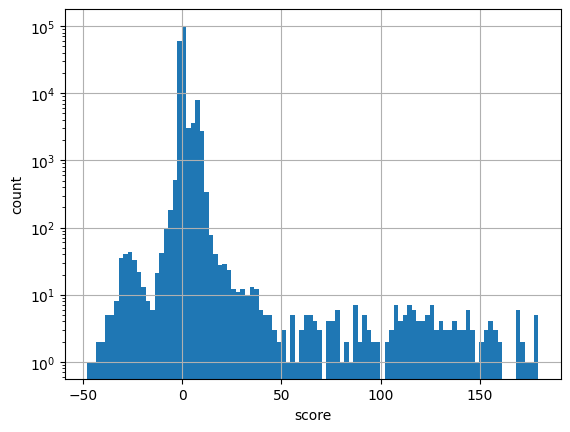

In [16]:

metadata['score'].hist(bins=100)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('score')
plt.show()

In [76]:
def ds_embs(md_table:pd.DataFrame, emb_arrs=[], vars_per_prot=62):
    idxs = []
    for esnp in md_table['ensp'].unique():
        esnp_vnts = md_table[md_table['ensp'] == esnp]
        idxs = idxs + esnp_vnts.iloc[np.random.choice(esnp_vnts.shape[0], size=vars_per_prot, replace=False),:].index.to_list()
    return md_table.loc[idxs], [arr[idxs, :] for arr in emb_arrs]
ds_md, (orig_aa_embs_ds, var_aa_embs_ds, orig_embs_ds, var_embs_ds) = ds_embs(metadata, [orig_aa_embs, var_aa_embs, orig_embs, var_embs])

In [77]:
# Write get emb df
def get_emb_df(
    orig_embs:np.ndarray,
    vnt_embs:np.ndarray,
    metadata:pd.DataFrame
):
    emb_df = pd.concat([
        pd.concat([pd.DataFrame(orig_embs, index=metadata.index), metadata], axis=1),
        pd.concat([pd.DataFrame(vnt_embs, index=metadata.index), metadata], axis=1)
    ], axis=0).reset_index(drop=True)
    emb_df['prot_version'] = ['orig' for i in range(orig_embs.shape[0])] + ['var' for i in range(vnt_embs.shape[0])]
    return emb_df

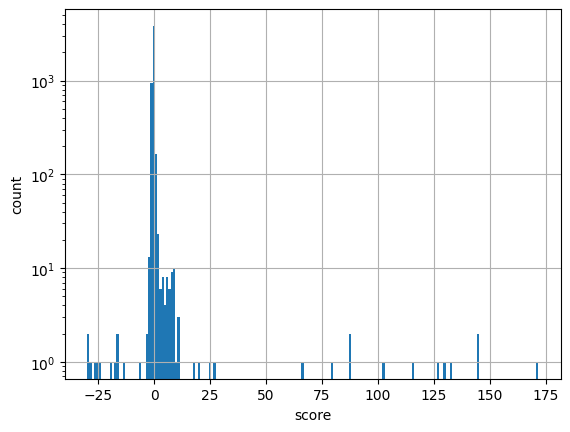

In [78]:
# Score distribution has some outliers, clip to +/-15
ds_md['score'].hist(bins=200)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('score')
plt.show()
ds_md['score'] = ds_md['score'].clip(-15,15)

AA embs

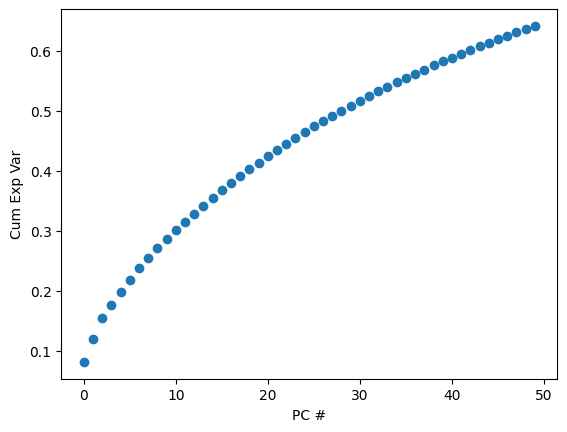

In [79]:
aa_emb_df = get_emb_df(orig_aa_embs_ds, var_aa_embs_ds, ds_md)
aa_pca_df, aa_pca_arr = get_pca_df(aa_emb_df, n_pc=50)

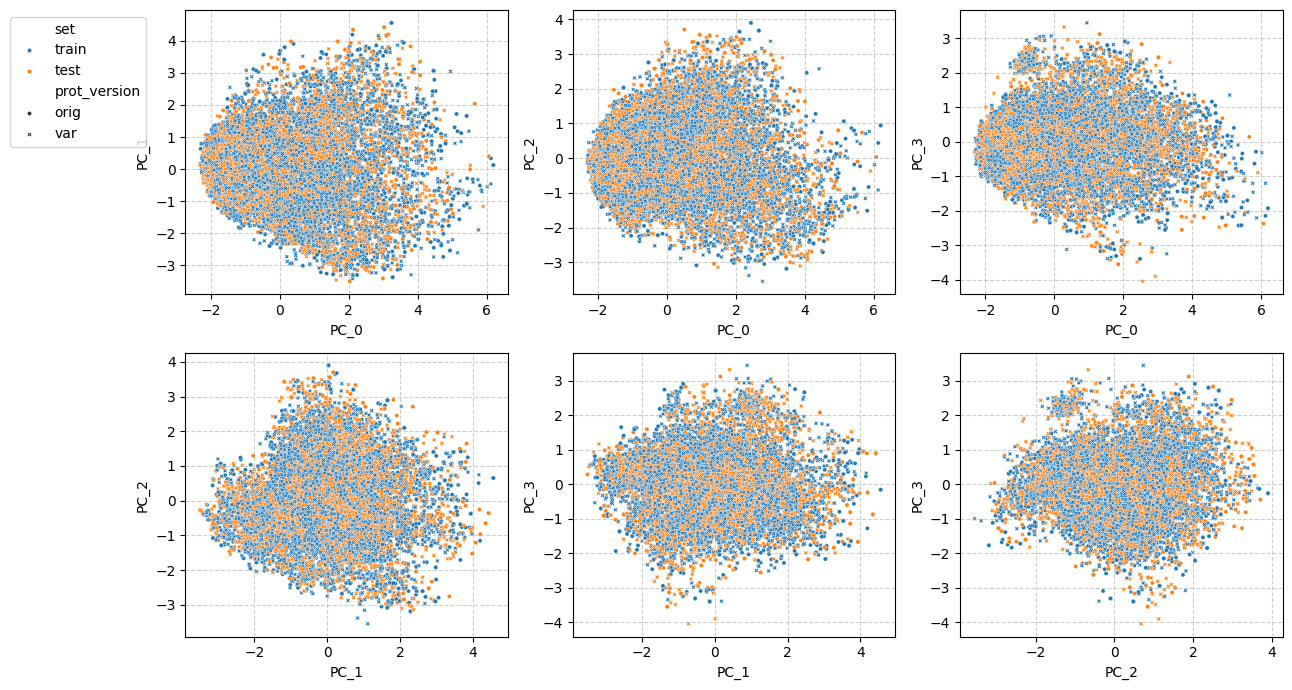

In [80]:
create_paneled_scatterplot_df(aa_pca_df, style='prot_version', hue_var='set', s=9)

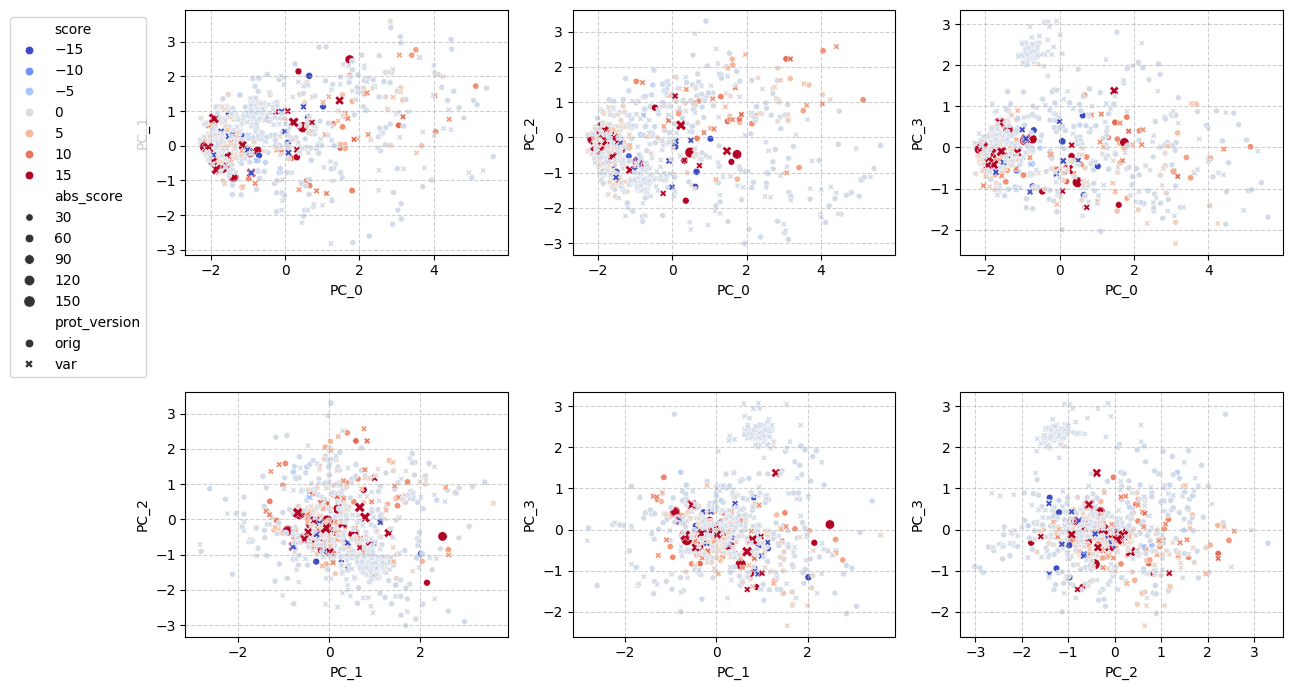

In [81]:
create_paneled_scatterplot_df(aa_pca_df[aa_pca_df['abs_score'] > 1],style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')

In [82]:
from umap import UMAP
reducer = UMAP(n_neighbors=100, )
umap_embs = reducer.fit_transform(aa_pca_arr)
aa_pca_df['UMAP_1'] = umap_embs[:,0]
aa_pca_df['UMAP_2'] = umap_embs[:,1]

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

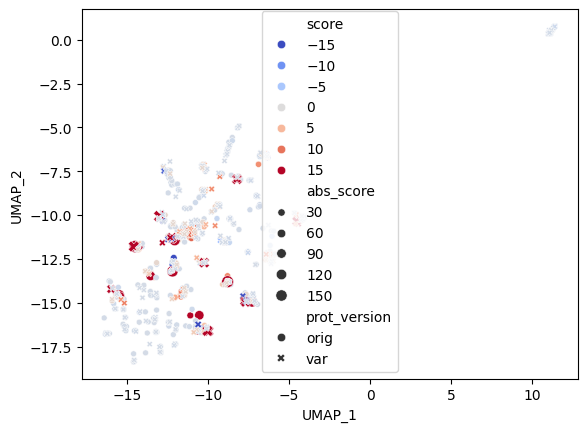

In [83]:
sns.scatterplot(aa_pca_df[aa_pca_df['abs_score'] > 1], x='UMAP_1', y='UMAP_2', style='prot_version', 
                hue='score', size='abs_score', palette='coolwarm')

<Axes: >

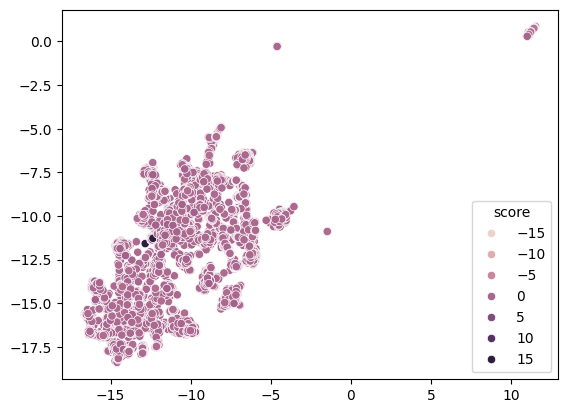

In [84]:
sns.scatterplot(x=umap_embs[:,0], y=umap_embs[:,1], hue=aa_pca_df['score'])

Diff between VNT and original embs

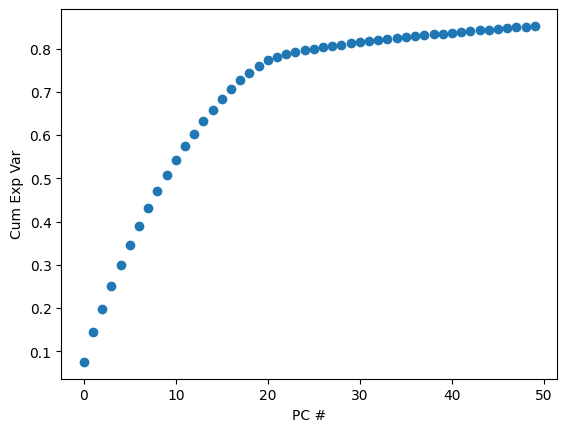

In [85]:
aa_diff_emb_df = pd.concat(
    [pd.DataFrame(var_aa_embs_ds - orig_aa_embs_ds, index=ds_md.index), ds_md], axis=1
    )
aa_diff_pca_df, aa_diff_pca_arr = get_pca_df(aa_diff_emb_df, n_pc=50)

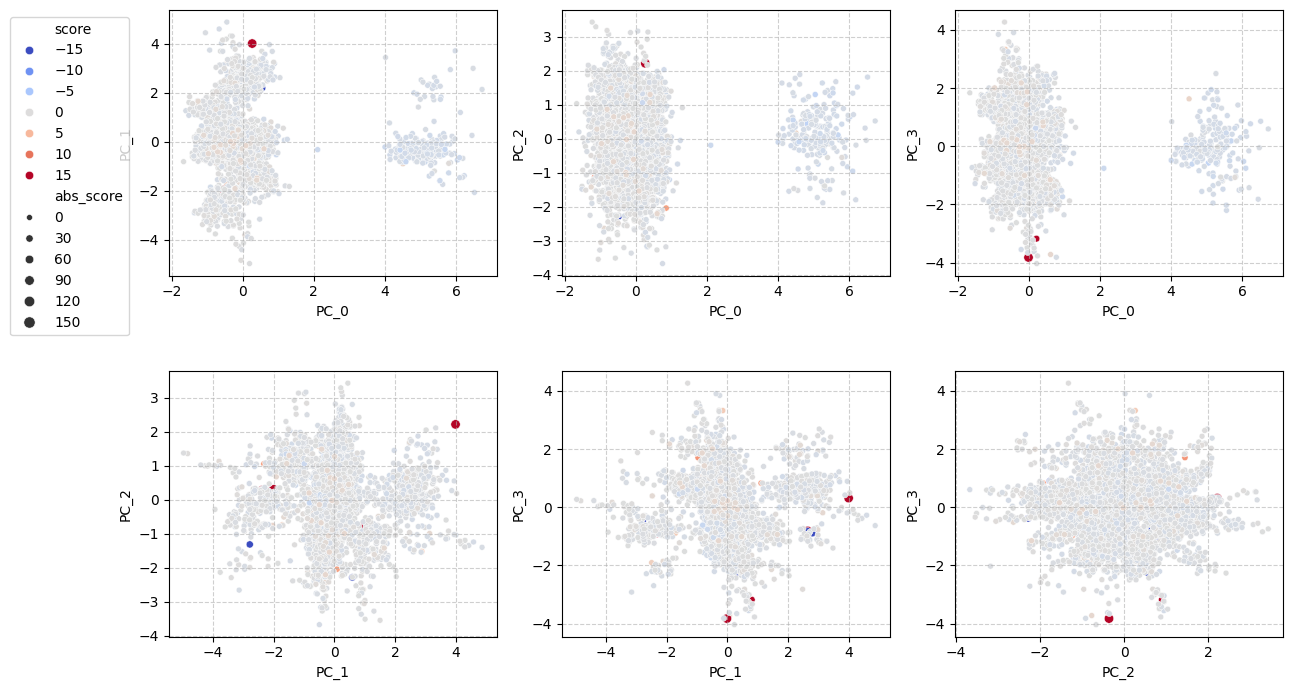

In [86]:
create_paneled_scatterplot_df(aa_diff_pca_df,
                              hue_var='score', size='abs_score', palette='coolwarm')

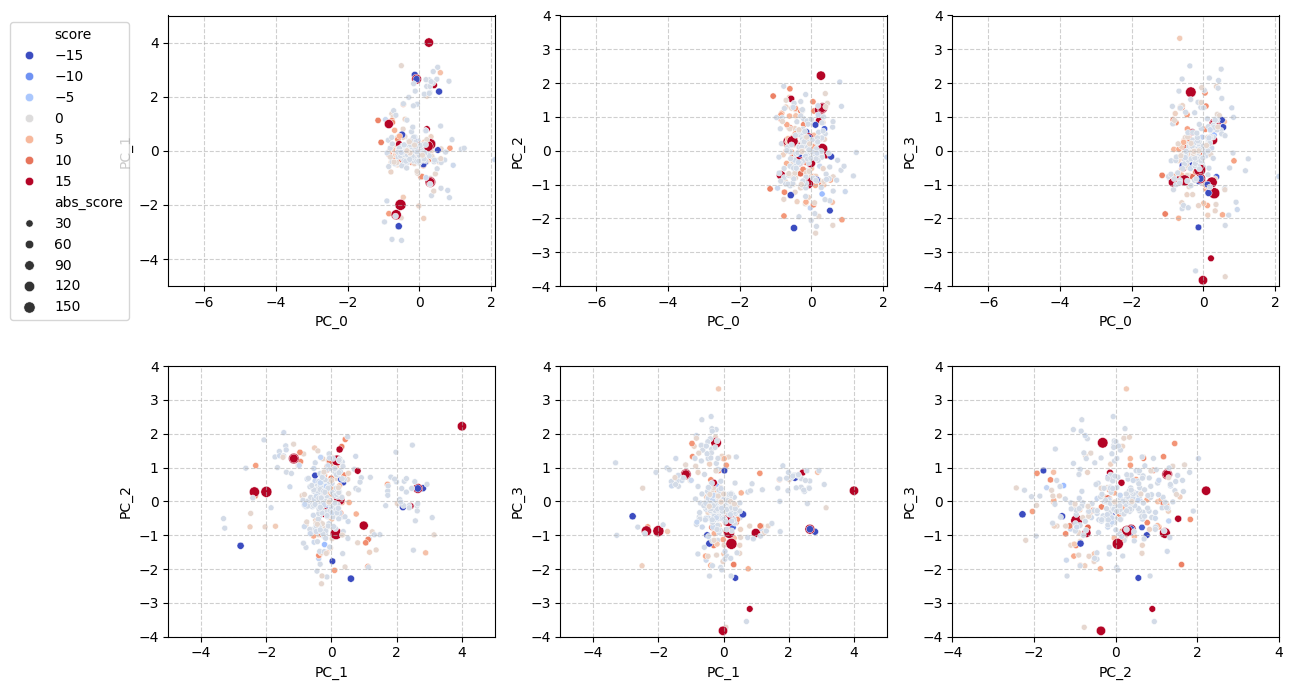

In [87]:
create_paneled_scatterplot_df(aa_diff_pca_df[aa_diff_pca_df['abs_score'] > 1], ax_lims=[(-7, 2.1), (-5,5), (-4,4), (-4,4)],
                              hue_var='score', size='abs_score', palette='coolwarm')

In [88]:
from umap import UMAP
reducer = UMAP(n_neighbors=200, )
umap_embs = reducer.fit_transform(aa_diff_pca_arr)
aa_diff_pca_df['UMAP_1'] = umap_embs[:,0]
aa_diff_pca_df['UMAP_2'] = umap_embs[:,1]

SystemError: CPUDispatcher(<function nn_descent at 0x000001D4401054E0>) returned a result with an exception set

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

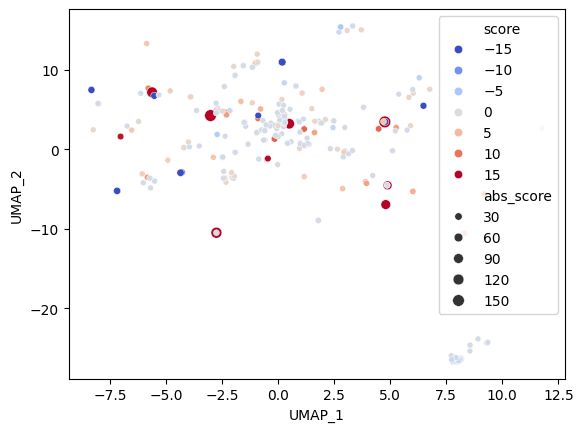

In [ ]:
sns.scatterplot(aa_diff_pca_df[aa_diff_pca_df['abs_score'] > 1], x='UMAP_1', y='UMAP_2',
                hue='score', size='abs_score', palette='coolwarm')

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

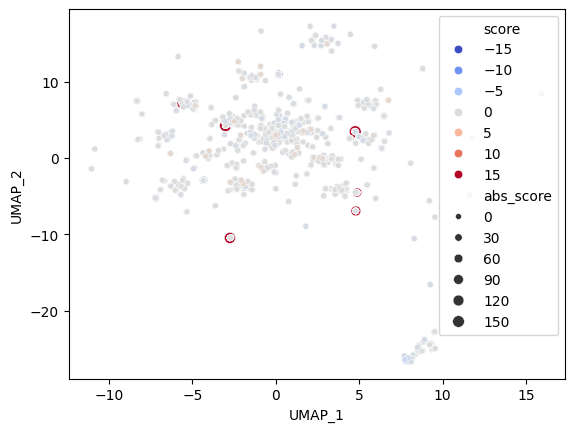

In [ ]:
sns.scatterplot(aa_diff_pca_df, x='UMAP_1', y='UMAP_2',
                hue='score', size='abs_score', palette='coolwarm')

VNT Embs Only

In [89]:
metadata.accession.value_counts()

accession
urn:mavedb:00000069-a-2#24                       1
urn:mavedb:00000069-a-2#25                       1
urn:mavedb:00000069-a-2#26                       1
urn:mavedb:00000069-a-2#27                       1
urn:mavedb:00000069-a-2#28                       1
                                                ..
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3724    1
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3725    1
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3726    1
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3727    1
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#3728    1
Name: count, Length: 296750, dtype: int64

In [90]:
ds_md['accession'].value_counts()

accession
urn:mavedb:00000069-a-2#1611                     1
urn:mavedb:00000069-a-1#2119                     1
urn:mavedb:00000069-a-1#680                      1
urn:mavedb:00000069-a-1#965                      1
urn:mavedb:00000069-a-1#527                      1
                                                ..
tmp:04d4176b-476e-427c-ab11-d8c1f26ebb2f#7588    1
tmp:8758394a-9513-4948-ba9e-71a33a593406#9363    1
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#8508    1
tmp:ec0eb518-1405-418a-a848-cc57fe8ce8bb#2616    1
tmp:1a14f665-fcc5-4244-baae-e22da846c65f#1782    1
Name: count, Length: 8432, dtype: int64

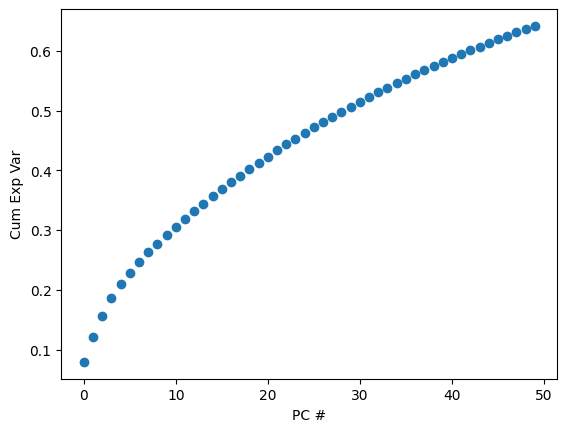

In [91]:
aa_vnt_emb_df = pd.concat(
    [pd.DataFrame(var_aa_embs_ds, index=ds_md.index), ds_md], axis=1
    )
aa_vnt_pca_df, aa_vnt_pca_arr = get_pca_df(aa_vnt_emb_df, n_pc=50)

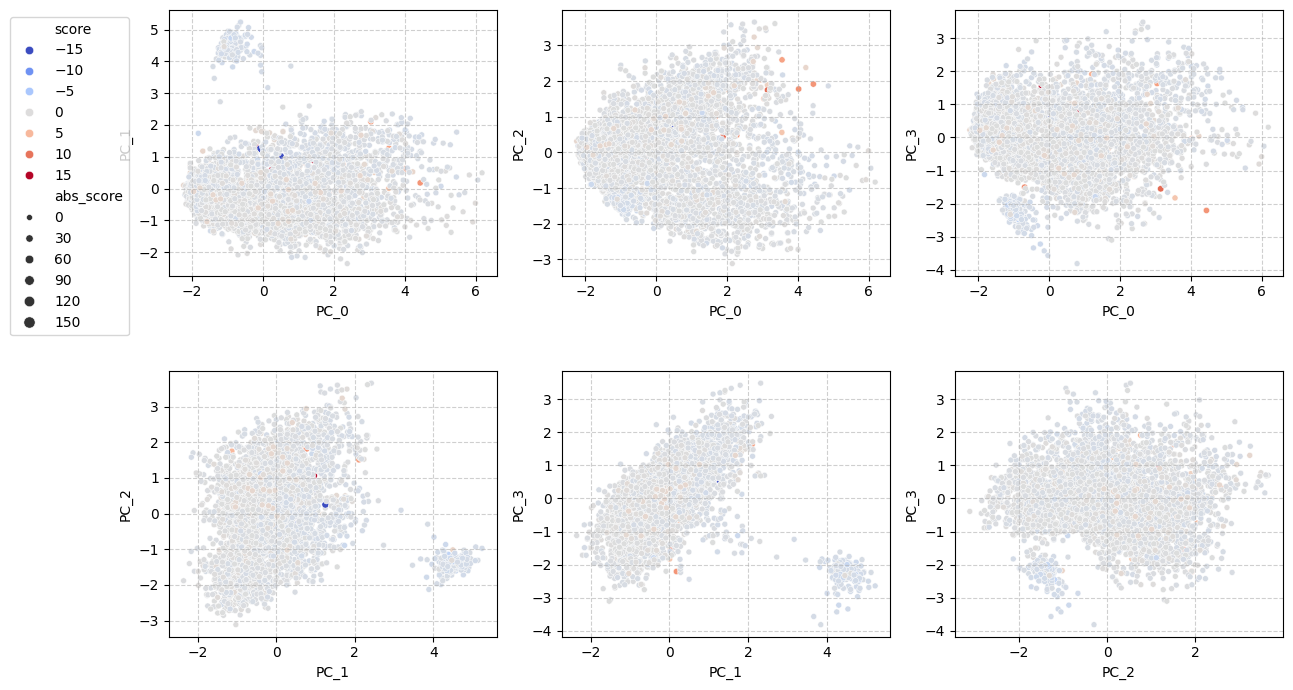

In [92]:
create_paneled_scatterplot_df(aa_vnt_pca_df,
                              hue_var='score', size='abs_score', palette='coolwarm')

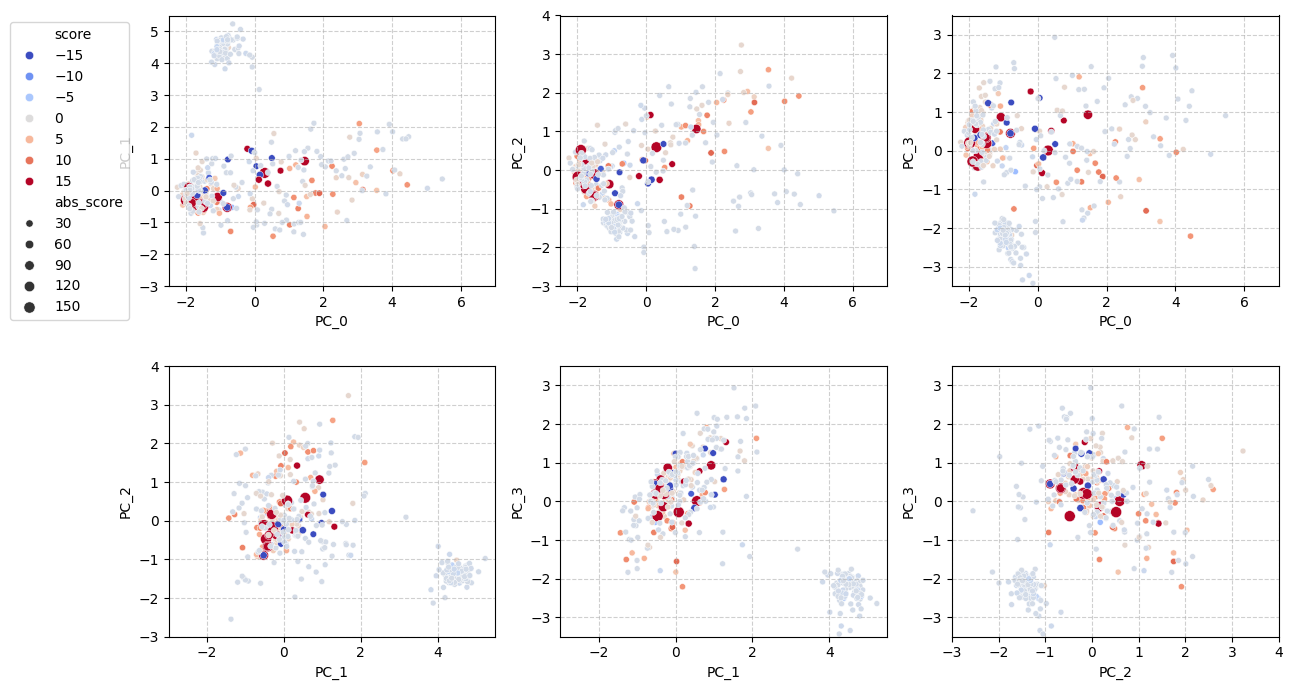

In [93]:
create_paneled_scatterplot_df(aa_vnt_pca_df[aa_vnt_pca_df['abs_score'] > 1], ax_lims=[(-2.5, 7), (-3,5.5), (-3,4), (-3.5,3.5)],
                              hue_var='score', size='abs_score', palette='coolwarm')

In [94]:
lr_res = pd.read_csv("data\zdanaceau_out_data\LinearRegressionResults.csv").set_index('accession')
lr_res

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_5384\1162346923.py:1: SyntaxWarning: invalid escape sequence '\z'
  lr_res = pd.read_csv("data\zdanaceau_out_data\LinearRegressionResults.csv").set_index('accession')


Unnamed: 0  \
accession                                                   
urn:mavedb:00000069-a-2#24                              0   
urn:mavedb:00000069-a-2#25                              1   
urn:mavedb:00000069-a-2#26                              2   
urn:mavedb:00000069-a-2#27                              3   
urn:mavedb:00000069-a-2#28                              4   
...                                                   ...   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9621      178495   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9622      178496   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9623      178497   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9624      178498   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9625      178499   

                                                              scoreset  \
accession                                                                
urn:mavedb:00000069-a-2#24                     urn:mavedb:00000069-a-2   
urn:mavedb:00000069-a-2#25                     urn:mavedb:00000069-a-2   
urn:mavedb:00000069-a-2#26                     urn:mavedb:00000069-a-2   
urn:mavedb:00000069-a-2#27                     urn:mavedb:00000069-a-2   
urn:mavedb:00000069-a-2#28                     urn:mavedb:00000069-a-2   
...                                                                ...   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9621  urn:mavedb:00001200-d-1   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9622  urn:mavedb:00001200-d-1   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9623  urn:mavedb:00001200-d-1   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9624  urn:mavedb:00001200-d-1   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9625  urn:mavedb:00001200-d-1   

                                                            ensp  \
accession                                                          
urn:mavedb:00000069-a-2#24                     ENSP00000252519.3   
urn:mavedb:00000069-a-2#25                     ENSP00000252519.3   
urn:mavedb:00000069-a-2#26                     ENSP00000252519.3   
urn:mavedb:00000069-a-2#27                     ENSP00000252519.3   
urn:mavedb:00000069-a-2#28                     ENSP00000252519.3   
...                                                          ...   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9621  ENSP00000218099.2   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9622  ENSP00000218099.2   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9623  ENSP00000218099.2   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9624  ENSP00000218099.2   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9625  ENSP00000218099.2   

                                               Score_standardized  \
accession                                                           
urn:mavedb:00000069-a-2#24                              -1.295126   
urn:mavedb:00000069-a-2#25                              -1.310270   
urn:mavedb:00000069-a-2#26                              -1.541214   
urn:mavedb:00000069-a-2#27                              -1.136999   
urn:mavedb:00000069-a-2#28                              -2.333410   
...                                                           ...   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9621            0.776685   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9622            1.036935   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9623            0.845742   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9624            0.236848   
tmp:4796e9d8-1601-4f7d-8788-8d062a0fc909#9625            0.616579   

                                               score_predicted  residuals  
accession                                                                  
urn:mavedb:00000069-a-2#24                           -1.871211  -0.576085  
urn:mavedb:00000069-a-2#25                           -1.817324  -0.507054  
urn:mavedb:00000069-a-2#26                           -1.685293  -0.144079  
urn:mavedb:00000069-a-2#27                           -1.722384  -0.585385  
urn:mavedb:00000069-a-2#28                         

np.int64(1)

In [139]:
aa_vnt_df_lr = aa_vnt_pca_df[aa_vnt_pca_df['set'] == 'train'].set_index('accession')
aa_vnt_df_lr = pd.concat([aa_vnt_df_lr, lr_res[['Score_standardized', 'score_predicted', 'residuals']]], axis=1)
aa_vnt_df_lr['Score_standardized'] = aa_vnt_df_lr['Score_standardized'].clip(-3,3)
aa_vnt_df_lr['abs_std_score'] = aa_vnt_df_lr['Score_standardized'].abs()

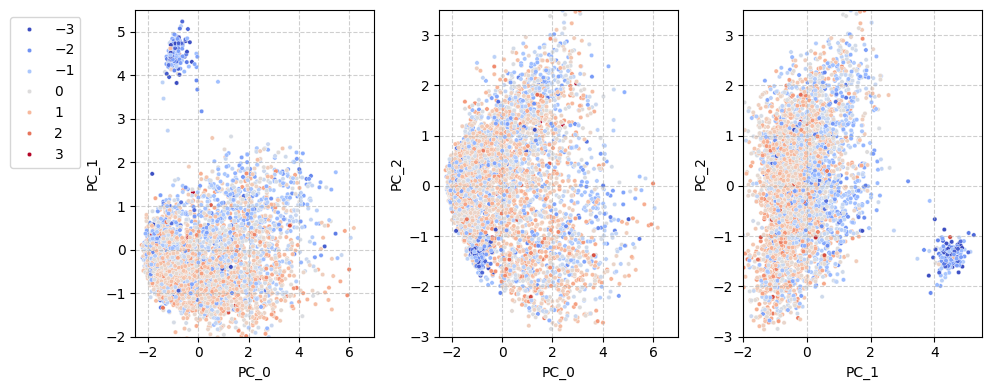

In [143]:
create_paneled_scatterplot_df(aa_vnt_df_lr, ax_lims=[(-2.5, 7), (-2,5.5), (-3,3.5), (-3.5,3.5)],
                              hue_var='Score_standardized', palette='coolwarm', s=10, n_pcs=3,
                              figsize=(10,4))

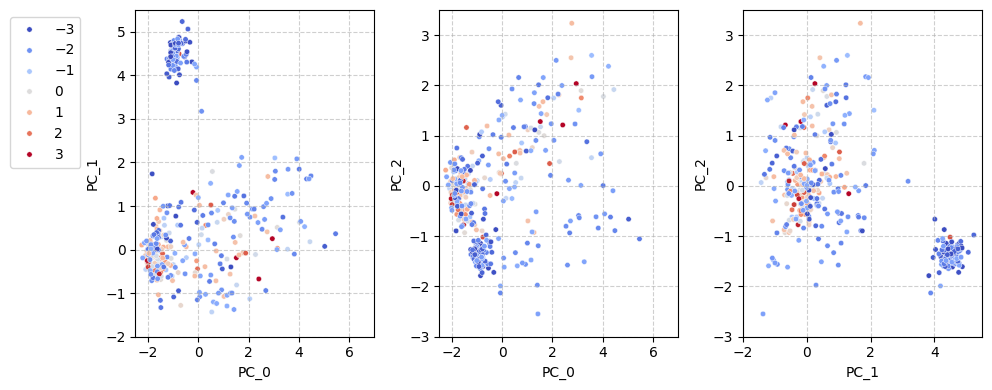

In [144]:
create_paneled_scatterplot_df(aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1], ax_lims=[(-2.5, 7), (-2,5.5), (-3,3.5), (-3.5,3.5)],
                              hue_var='Score_standardized', palette='coolwarm', s=15, n_pcs=3, figsize=(10,4))

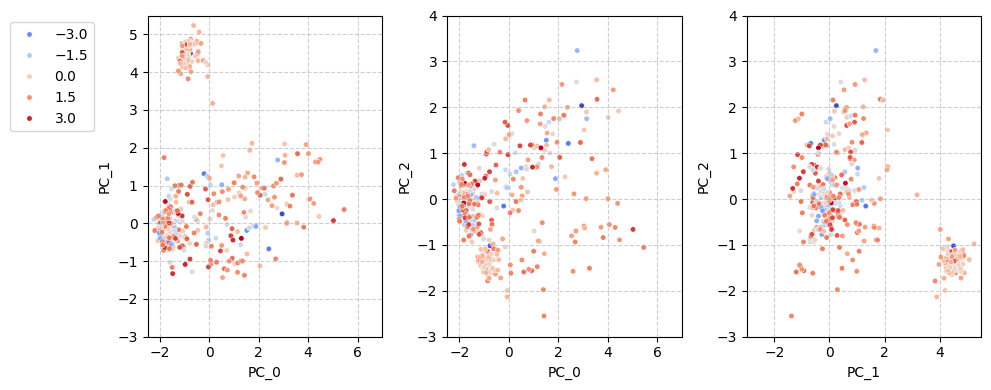

In [145]:
create_paneled_scatterplot_df(aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1], ax_lims=[(-2.5, 7), (-3,5.5), (-3,4), (-3.5,3.5)],
                              hue_var='residuals', palette='coolwarm', s=15,  n_pcs=3, figsize=(10,4))

<Axes: xlabel='Score_standardized', ylabel='residuals'>

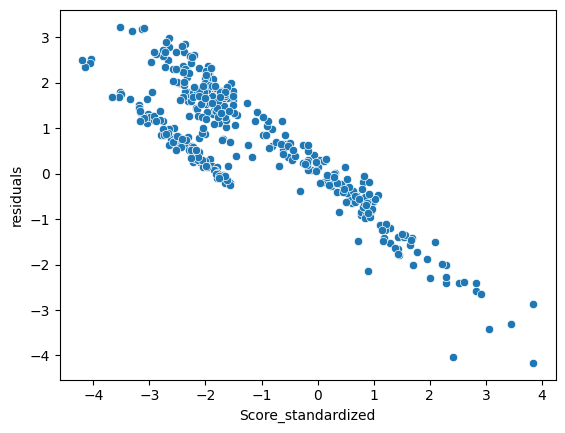

In [125]:
sns.scatterplot(aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1], x='Score_standardized', y='residuals')

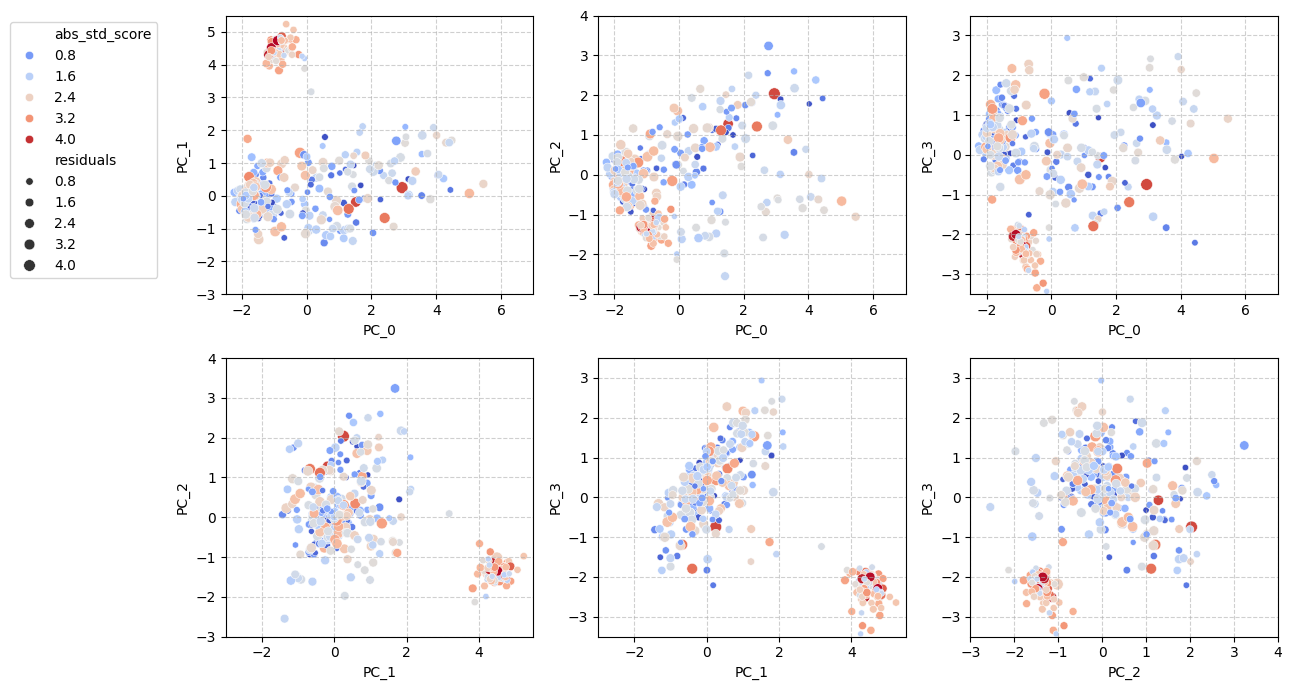

In [113]:
create_paneled_scatterplot_df(aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1], ax_lims=[(-2.5, 7), (-3,5.5), (-3,4), (-3.5,3.5)],
                              hue_var='abs_std_score', size=aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1]['residuals'].abs(), palette='coolwarm')

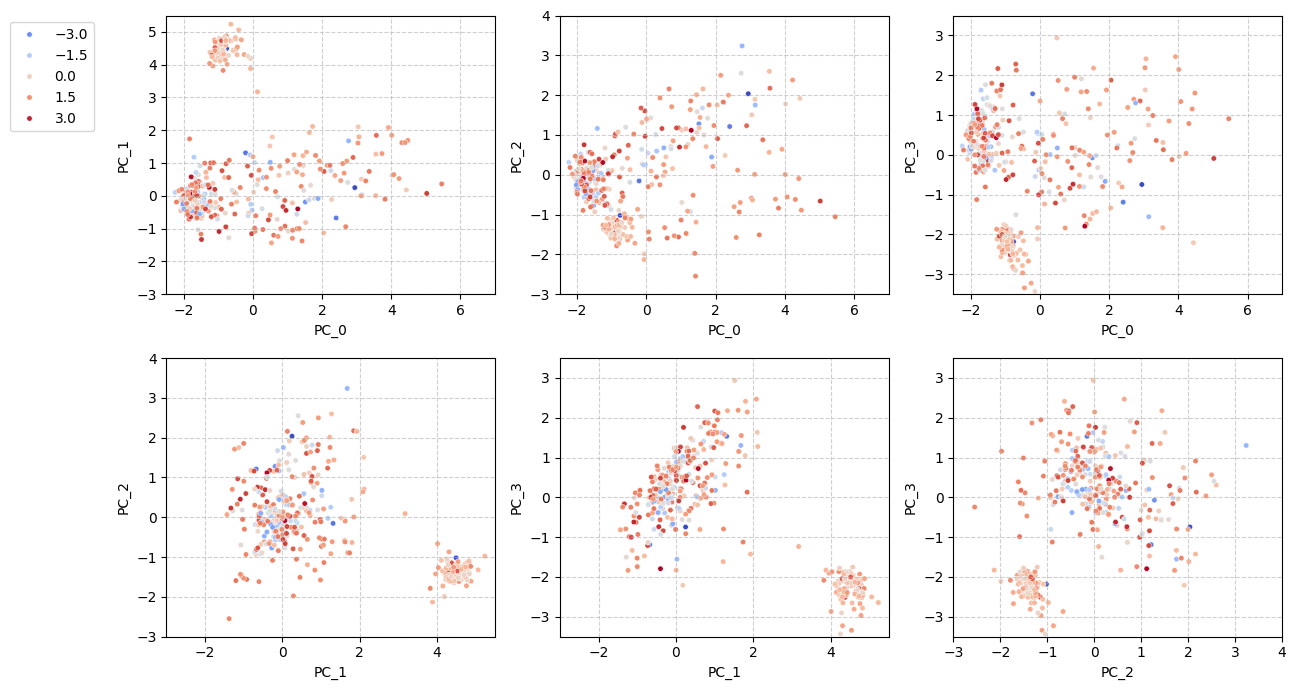

In [147]:
create_paneled_scatterplot_df(aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1], ax_lims=[(-2.5, 7), (-3,5.5), (-3,4), (-3.5,3.5)],
                              hue_var=aa_vnt_df_lr[aa_vnt_df_lr['abs_score'] > 1]['residuals'], palette='coolwarm', s=15)